# Representation Learning with Contrastive and Triplet Losses

In this notebook we are going to explore what kind of feature spaces we get from using contrastive and triplet losses.

### Preparing the environment

Since I'll be running this at our servers, this code will set up tensorflow to use only one GPU and not fill up the VRAM memory. We'll also be importing tensorflow here

In [1]:
import tensorflow as tf

def setup_gpu(gpu_ids):

    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            sel_gpus = [gpus[g] for g in gpu_ids]
            tf.config.set_visible_devices(sel_gpus, 'GPU')
            for g in sel_gpus:
                tf.config.experimental.set_memory_growth(g, True)
        except RuntimeError as e:
            # visible devices must be set before GPUs have been initialized
            print(e)
            
setup_gpu([0])

## Contrastive Loss

### Preparing the dataset
We'll start with the contrastive loss. For this experiment we'll be using MNIST, so let's load it up

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
# notice that we need to do some preprocessing first
x_train[0, :10, :10]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  30,  36],
       [  0,   0,   0,   0,   0,   0,   0,  49, 238, 253],
       [  0,   0,   0,   0,   0,   0,   0,  18, 219, 253],
       [  0,   0,   0,   0,   0,   0,   0,   0,  80, 156]], dtype=uint8)

In [4]:
x_train, x_test = x_train / 255., x_test / 255.
x_train, x_test = x_train[..., None], x_test[..., None]

### Rearanging the dataset

To train with contrastive loss, we are going to need the data to come in pairs, labelled as to their semantic similarity. We are going to achieve that with an index and a python generator

In [5]:
# we can index the data by class so that pairs can be easily made later
indexed_mnist = [[]]*10
for x, y in zip(x_train, y_train):
    indexed_mnist[y].append(x)
    
# to make things faster we can also make a negative class index
negative_class_index = [[]]*10
for c in range(10):
    negative_class_index[c] = list(range(10))
    negative_class_index[c].remove(c)    

In [22]:
import random

# now we can make a generator that goes over the dataset and picks one similar pair
# and one dissimilar pair at each cycle
def contrastive_iterator():
    i = 0
    while True:
        i += 1
        
        # take a random sample to be our anchor
        idx = random.randint(0, len(x_train)-1)
        x, y = x_train[idx], y_train[idx]
        
        # use our negative classes index to
        # take a random sample from a random negative class   
        if i % 2 == 0:
            random_negative_class = random.choice(negative_class_index[y])
            x_n = random.choice(indexed_mnist[random_negative_class])
            yield x, x_n, 1

        # random sample from positive class
        if i % 2 != 0:
            x_p = random.choice(indexed_mnist[y])
            yield x, x_p, 0

In [23]:
# finally, we take our generator and make a nice tf dataset out of it
dataset_contrastive = tf.data.Dataset.from_generator(
    contrastive_iterator, 
    output_signature=(tf.TensorSpec(shape=(28, 28, 1), dtype=tf.float32),
                     tf.TensorSpec(shape=(28, 28, 1), dtype=tf.float32),
                     tf.TensorSpec(shape=(), dtype=tf.int32))
)

In [24]:
# let's also leave our test set prepared
# note that our test set does not need to be organised in pairs
dataset_test = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_test), 
                                    tf.data.Dataset.from_tensor_slices(y_test)))

### Making our network

We are going to build our network using two models: one model is the actual network and the other one will rearange our model with two inputs and be the one used for training

In [25]:
# the encoder model
x_input = tf.keras.Input([28, 28, 1])
x = tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same')(x_input)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same')(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(16)(x)

encoder_model = tf.keras.Model(x_input, x)
encoder_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
global_average_pooling2d_2 ( (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
Total params: 38,608
Trainable params: 38,608
Non-trainable params: 0
_______________________________________________________

In [26]:
# let's keep it simple here
optimiser = tf.keras.optimizers.Adam()

### The Contrastive Loss

Now for the moment we've been waiting for, the contrastive loss! Let's recap the equation:

$ \mathcal{L}(W, (Y, x_1, x_2)) = \frac{1}{2} (1-Y)(D(W,x_1,x_2))^2 +\ \frac{1}{2}Y \max \{0,\ m-D(W,x_1,x_2)\}^2  $

In [27]:
def euclidean_distance(a, b):
    sum_squared = tf.reduce_sum(tf.square(a - b), axis=1)
    return tf.sqrt(tf.maximum(sum_squared, tf.keras.backend.epsilon()))

def make_contrastive_loss(margin=0.5):
    def contrastive_loss(a_rep, b_rep, sim_label):
        
        dis = euclidean_distance(a_rep, b_rep)
        d_p = tf.square(dis)
        d_n = tf.square(tf.maximum(0., margin - dis))
        
        sim_label = tf.cast(sim_label, tf.float32)[..., None]
        loss = (0.5)*(1 - sim_label)*d_p + (0.5)*sim_label*d_n
        return tf.reduce_mean(loss)
    return contrastive_loss

our_contrastive = make_contrastive_loss(margin=1.)

## Finally, training

Now we are going to prepare our training functions and loop

#### The Model Trainer

For the training function, we are going to compute reps for the pair, compute the loss and then apply the gradients as usual

In [28]:
@tf.function
def train(x_as, x_bs, ys):
    with tf.GradientTape() as tape:
        a_reps = encoder_model(x_as)
        b_reps = encoder_model(x_bs)
        loss = our_contrastive(a_reps, b_reps, ys)

    optimiser.apply_gradients(
        zip(tape.gradient(loss, encoder_model.trainable_variables), encoder_model.trainable_variables))
    return loss

#### And the training loop

In [29]:
counter = 0
for x_as, x_bs, ys in dataset_contrastive.batch(32):
    loss = train(x_as, x_bs, ys)
    
    if counter >= 10000:
        break
    
    counter += 1
    
    if counter % 100 == 0:
        print(f"It {counter}, loss: {loss}", end='\r')

### Did it work?

Now we are going to do a plot of the feature space (reduced with PCA) and we are going to do a search

In [31]:
import numpy as np

# let's apply the network to the test set and check how it looks
def evaluate(encoder):
    all_reps, all_ys = [], []
    for x, y in dataset_test.batch(32):
        rep = encoder(x)
        all_reps.append(rep)
        all_ys.append(y)

    all_reps = np.concatenate(all_reps, axis=0)
    all_ys = np.concatenate(all_ys, axis=0)
    return all_reps, all_ys
all_reps, all_ys = evaluate(encoder_model)

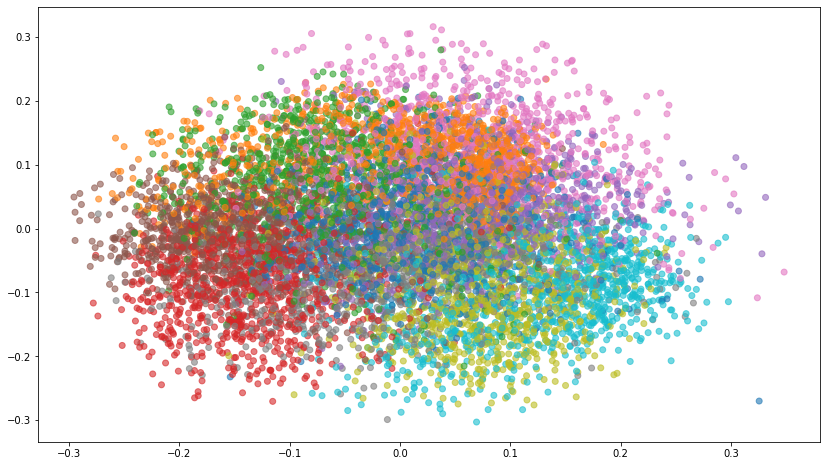

In [33]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.colors as colors
import matplotlib.cm as cm
%matplotlib inline

# and plot using PCA
def visualisation(all_reps, all_ys, n_to_plot=10000):

    idx = np.random.permutation(len(all_reps))[:n_to_plot]
    all_reps = all_reps[idx]

    pca = PCA(n_components=2)
    pca.fit(all_reps)
    pca_result = pca.transform(all_reps)

    cmapper = cm.ScalarMappable(cmap=cm.tab10)
    mapped_colors = cmapper.to_rgba(all_ys[idx])

    plt.figure(figsize=(14, 8))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=mapped_colors, alpha=0.6)
visualisation(all_reps, all_ys)

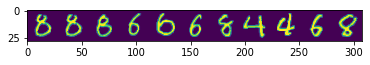

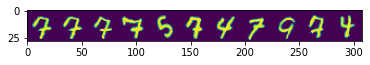

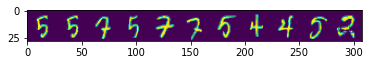

In [48]:
def search(all_reps):
    
    # take five samples
    idx = np.random.permutation(len(all_reps))[:3]
    sel_reps = all_reps[idx]
    sel_images = x_test[idx]
    
    # do a search with each of them
    for image, sel_rep in zip(sel_images, sel_reps):
        distances = []
        for rep in all_reps:
            distances.append(np.sum(np.square(sel_rep - rep)))
        top5_idx = np.argsort(distances)[:10]
        search_vis = np.concatenate([image, np.concatenate(x_test[top5_idx], axis=1)], axis=1)
        plt.imshow(search_vis)
        plt.show()
search(all_reps)

## Triplet Loss

Now we do it all again for the triplet loss. Here is what we need to change:

- Dataset arangement (we need triples now)
- Reset the network weights
- Of course, the loss function
- The trainer

### Our generator is very similar, we just yield the full triplet now

In [61]:
def triplet_iterator():
    while True:
        idx = random.randint(0, len(x_train)-1)
        x, y = x_train[idx], y_train[idx]
        
        random_negative_class = random.choice(negative_class_index[y])
        x_n = random.choice(indexed_mnist[random_negative_class])
        
        x_p = random.choice(indexed_mnist[y])
        
        yield x, x_p, x_n


dataset_triplet = tf.data.Dataset.from_generator(
    triplet_iterator, 
    output_signature=(tf.TensorSpec(shape=(28, 28, 1), dtype=tf.float32),
                     tf.TensorSpec(shape=(28, 28, 1), dtype=tf.float32),
                     tf.TensorSpec(shape=(28, 28, 1), dtype=tf.float32))
)

### Resetting the model

The easiest way is to just make another one

In [62]:
x_input = tf.keras.Input([28, 28, 1])
x = tf.keras.layers.Conv2D(64, kernel_size=2, activation='relu', padding='same')(x_input)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, kernel_size=2, activation='relu', padding='same')(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(16)(x)
x = tf.math.l2_normalize(x)  # triplets can break without normalisation

encoder_model_b = tf.keras.Model(x_input, x)
encoder_model_b.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 64)        16448     
_________________________________________________________________
global_average_pooling2d_4 ( (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                1040      
_________________________________________________________________
tf.math.l2_normalize_1 (TFOp (None, 16)                0   

### The Triplet Loss

Recapping the equation:

$ \mathcal{L}(x_a, x_p, x_n) = \frac{1}{2} \max\{0,\ m + D(x_a, x_p) - D(x_a, x_n) \} $

In [63]:
def make_triplet_loss(margin=0.5):
    def triplet_loss(a_rep, p_rep, n_rep):
        
        d_p = euclidean_distance(a_rep, p_rep)
        d_n = euclidean_distance(a_rep, n_rep)

        loss = tf.maximum(0., margin + d_p - d_n)

        return tf.reduce_mean(loss)
    return triplet_loss

our_triplet = make_triplet_loss(margin=0.5)

### Re-doing the model trainer and loop

In [64]:
@tf.function
def train(x_as, x_ps, x_ns):
    with tf.GradientTape() as tape:
        a_reps = encoder_model_b(x_as)
        p_reps = encoder_model_b(x_ps)
        n_reps = encoder_model_b(x_ns)
        loss = our_triplet(a_reps, p_reps, n_reps)

    optimiser.apply_gradients(
        zip(tape.gradient(loss, encoder_model_b.trainable_variables), encoder_model_b.trainable_variables))
    return loss

In [65]:
counter = 0
for x_as, x_ps, x_ns in dataset_triplet.batch(32):
    loss = train(x_as, x_ps, x_ns)
    
    counter += 1
    if counter >= 10000:
        break

    if counter % 100 == 0:
        print(f"It {counter}, loss: {loss}", end='\r')

### And now we check if it is working!

In [66]:
all_reps, all_ys = evaluate(encoder_model_b)

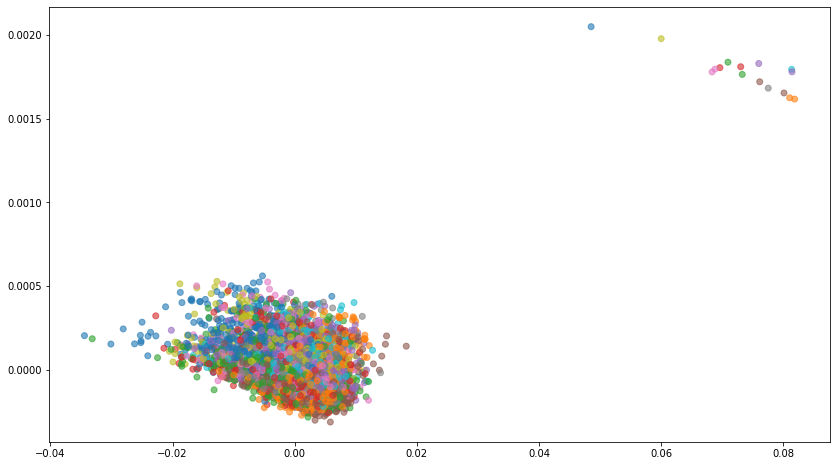

In [67]:
visualisation(all_reps, all_ys)

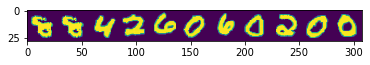

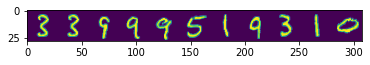

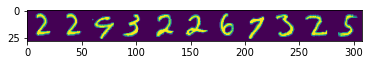

In [68]:
search(all_reps)